# Evaluation Metrics Part 1 - Basics

## Learning Objectives
By the end of this notebook, you will be able to:
1. Build and interpret confusion matrices
2. Calculate accuracy, precision, recall, and F1 score
3. Understand the "accuracy trap" with imbalanced data
4. Know when to use which metric
5. Evaluate models comprehensively (not just accuracy)



## Introduction: Why Evaluation Metrics Matter

Building a classification model is only half the battle. The other half is **evaluating** how well it performs.

**Why evaluation matters:**
- **Compare models** to choose the best one
- **Identify problems** before deploying to production
- **Set business expectations** about model performance
- **Debug issues** when models don't work as expected
- **Communicate results** to stakeholders

**The Accuracy Trap:**
Many people think accuracy is the only metric that matters. But accuracy can be **misleading**, especially with imbalanced data!

**Think About It:** If 95% of customers don't churn, what accuracy would a "dumb" model that always predicts "no churn" achieve? Is this a good model?

In this notebook, we'll explore the essential evaluation metrics and learn when to use each one.


In [25]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to explore evaluation metrics!")


Libraries imported successfully!
Ready to explore evaluation metrics!


In [26]:
# Load and prepare the Telco Customer Churn dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"

try:
    df = pd.read_csv(url)
    print("✅ Dataset loaded successfully!")
except:
    print("❌ Could not load from URL. Please check your internet connection.")

# Clean the data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Prepare data for modeling
features = ['tenure', 'MonthlyCharges', 'TotalCharges']
X = df[features]
y = (df['Churn'] == 'Yes').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"Dataset shape: {df.shape}")
print(f"Features: {features}")
print(f"Training set: {X_train.shape[0]:,} customers")
print(f"Testing set: {X_test.shape[0]:,} customers")
print(f"Churn rate: {y.mean():.1%}")


✅ Dataset loaded successfully!
Dataset shape: (7043, 21)
Features: ['tenure', 'MonthlyCharges', 'TotalCharges']
Training set: 5,634 customers
Testing set: 1,409 customers
Churn rate: 26.5%


## Section 1: The Confusion Matrix - Foundation of All Metrics

The confusion matrix is the foundation for all classification metrics. It shows exactly what our model got right and wrong.


In [27]:
# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

# Create a more detailed confusion matrix with labels
cm_df = pd.DataFrame(cm, 
                     index=['Actual: No Churn', 'Actual: Churn'],
                     columns=['Predicted: No Churn', 'Predicted: Churn'])

print("\nConfusion Matrix with Labels:")
print(cm_df)

# Extract the four components
tn, fp, fn, tp = cm.ravel()

print(f"\nBreaking Down the Confusion Matrix:")
print(f"True Negatives (TN):  {tn:,} - Correctly predicted 'No Churn'")
print(f"False Positives (FP): {fp:,} - Incorrectly predicted 'Churn' (Type I Error)")
print(f"False Negatives (FN): {fn:,} - Incorrectly predicted 'No Churn' (Type II Error)")
print(f"True Positives (TP):  {tp:,} - Correctly predicted 'Churn'")


Confusion Matrix:
[[932 103]
 [217 157]]

Confusion Matrix with Labels:
                  Predicted: No Churn  Predicted: Churn
Actual: No Churn                  932               103
Actual: Churn                     217               157

Breaking Down the Confusion Matrix:
True Negatives (TN):  932 - Correctly predicted 'No Churn'
False Positives (FP): 103 - Incorrectly predicted 'Churn' (Type I Error)
False Negatives (FN): 217 - Incorrectly predicted 'No Churn' (Type II Error)
True Positives (TP):  157 - Correctly predicted 'Churn'


### Business Interpretation

**Understanding the Confusion Matrix Components:**

- **True Negatives (TN):** Customers correctly identified as staying
- **False Positives (FP):** Customers incorrectly flagged for churn (false alarms)
- **False Negatives (FN):** Customers who churned but we missed (missed opportunities)
- **True Positives (TP):** Customers correctly identified as churning

**Key Insights:**
- The diagonal shows correct predictions (TN and TP)
- Off-diagonal shows errors (FP and FN)
- False Positives waste resources on customers who won't churn
- False Negatives miss opportunities to retain customers who will churn


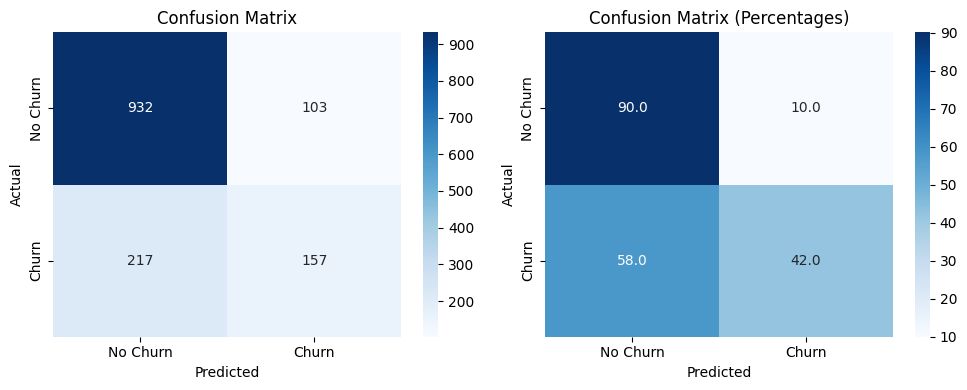

In [28]:
# Visualize the confusion matrix
plt.figure(figsize=(10, 4))

# Plot 1: Basic confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 2: Confusion matrix with percentages
plt.subplot(1, 2, 2)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix (Percentages)')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


### Visual Insights

**Understanding the Heatmaps:**

- **Darker colors** indicate higher counts
- **The diagonal** shows correct predictions (TN and TP)
- **Off-diagonal** shows errors (FP and FN)
- **Percentages** show the proportion of each actual class
- **Left plot** shows raw counts, **right plot** shows percentages


## Section 2: The Accuracy Trap - Why 95% Accuracy Can Be Useless

Let's see why accuracy alone can be misleading, especially with imbalanced data.


In [29]:
# Calculate accuracy for our model
accuracy = accuracy_score(y_test, y_pred)

# Create a "dumb" model that always predicts "No Churn"
dumb_predictions = np.zeros(len(y_test))  # All predictions are 0 (No Churn)
dumb_accuracy = accuracy_score(y_test, dumb_predictions)

# Show the confusion matrix for the dumb model
dumb_cm = confusion_matrix(y_test, dumb_predictions)
dumb_tn, dumb_fp, dumb_fn, dumb_tp = dumb_cm.ravel()

print(f"Our Model Accuracy: {accuracy:.1%}")
print(f"Dumb Model Accuracy: {dumb_accuracy:.1%} (Always predicts 'No Churn')")
print(f"\nDumb Model Confusion Matrix:")
print(f"True Negatives: {dumb_tn:,}")
print(f"False Positives: {dumb_fp:,}")
print(f"False Negatives: {dumb_fn:,}")
print(f"True Positives: {dumb_tp:,}")


Our Model Accuracy: 77.3%
Dumb Model Accuracy: 73.5% (Always predicts 'No Churn')

Dumb Model Confusion Matrix:
True Negatives: 1,035
False Positives: 0
False Negatives: 374
True Positives: 0


### The Accuracy Trap

**The Problem:**
- The dumb model achieves high accuracy by always predicting "No Churn"
- But it never predicts churn (TP = 0)
- It misses ALL customers who actually churn!
- This model is completely useless for business purposes!

**Key Insight:**
- High accuracy doesn't mean a good model
- We need metrics that focus on the minority class (churn)
- This is why we need precision, recall, and F1 score


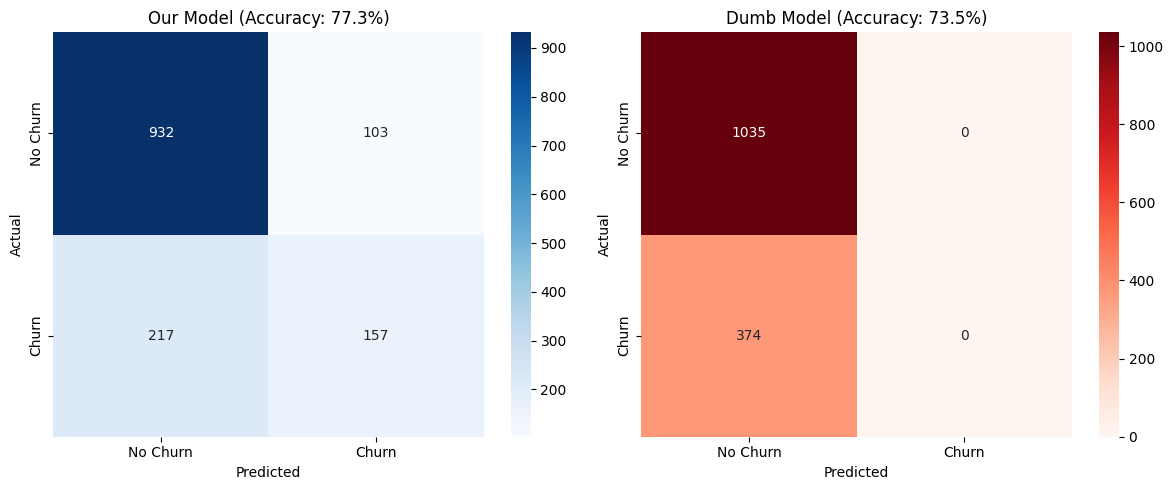

In [30]:
# Visualize the accuracy trap
plt.figure(figsize=(12, 5))

# Plot 1: Our model confusion matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Our Model (Accuracy: {accuracy:.1%})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 2: Dumb model confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(dumb_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Dumb Model (Accuracy: {dumb_accuracy:.1%})')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


### Visual Comparison

**Key Observations:**
- Both models have similar accuracy
- But our model actually predicts churn (bottom-right cell)
- Dumb model never predicts churn (bottom-right = 0)
- This shows why accuracy alone is insufficient!


## Section 3: Precision and Recall - The Essential Metrics

Precision and recall focus on the minority class (churn) and give us much better insights than accuracy alone.


In [31]:
# Calculate precision and recall manually
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"Precision = TP / (TP + FP) = {tp} / ({tp} + {fp}) = {precision:.3f}")
print(f"Recall = TP / (TP + FN) = {tp} / ({tp} + {fn}) = {recall:.3f}")

# Verify with sklearn
sklearn_precision = precision_score(y_test, y_pred)
sklearn_recall = recall_score(y_test, y_pred)

print(f"\nVerification with sklearn:")
print(f"Precision: {sklearn_precision:.3f}")
print(f"Recall: {sklearn_recall:.3f}")


Precision = TP / (TP + FP) = 157 / (157 + 103) = 0.604
Recall = TP / (TP + FN) = 157 / (157 + 217) = 0.420

Verification with sklearn:
Precision: 0.604
Recall: 0.420


### Business Interpretation

**Precision:** Of all customers we predicted would churn, what percentage actually did churn? This measures "accuracy of positive predictions."

**Recall:** Of all customers who actually churned, what percentage were correctly identified? This measures "coverage of actual churners."

**Key Questions:**
- **Precision:** "When I say churn, how often am I right?"
- **Recall:** "When someone churns, how often do I catch them?"


In [32]:
# Show the actual calculated values
print(f"Actual Results:")
print(f"Precision: {precision:.1%} - Of all customers predicted to churn, {precision:.1%} actually churned")
print(f"Recall: {recall:.1%} - Of all customers who churned, {recall:.1%} were correctly identified")


Actual Results:
Precision: 60.4% - Of all customers predicted to churn, 60.4% actually churned
Recall: 42.0% - Of all customers who churned, 42.0% were correctly identified


In [33]:
# Compare our model vs dumb model on precision and recall
dumb_precision = dumb_tp / (dumb_tp + dumb_fp) if (dumb_tp + dumb_fp) > 0 else 0
dumb_recall = dumb_tp / (dumb_tp + dumb_fn) if (dumb_tp + dumb_fn) > 0 else 0

print("Model Comparison:")
print(f"{'Metric':<12} {'Our Model':<12} {'Dumb Model':<12}")
print("-" * 40)
print(f"{'Accuracy':<12} {accuracy:<12.1%} {dumb_accuracy:<12.1%}")
print(f"{'Precision':<12} {precision:<12.1%} {dumb_precision:<12.1%}")
print(f"{'Recall':<12} {recall:<12.1%} {dumb_recall:<12.1%}")


Model Comparison:
Metric       Our Model    Dumb Model  
----------------------------------------
Accuracy     77.3%        73.5%       
Precision    60.4%        0.0%        
Recall       42.0%        0.0%        


### Key Insights

**Why Precision and Recall Matter:**
- Accuracy is similar for both models
- But precision and recall reveal the truth!
- Dumb model has 0% precision and 0% recall
- Our model actually identifies churners!

**Visual Representation:**
- **Precision:** "When I say churn, how often am I right?"
- **Recall:** "When someone churns, how often do I catch them?"
- Both metrics focus on the minority class (churn)
- This makes them much more useful than accuracy!
